### ZeroAccess

* Where ZeroAccess occurs? Any patterns?
* What kind of users are easily to be infected? Does education or income affect infection rate?
* Does UFO cause ZeroAccess infection?



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
z_df = pd.read_csv("https://drive.google.com/uc?id=13iE3A-OO_oWZrEvDmpN_nA6yPfLpCiZv") # zeroaccess.csv
s_df = pd.read_csv("https://drive.google.com/uc?id=13nE04n2MwRAMFSPxS96dYMe1RYgZujxS") # state-internets.csv
c_df = pd.read_csv("https://drive.google.com/uc?id=13qH1zWX4FQGNo43m_7ufSsDUbYUxa81O") # county-data.csv

In [ ]:
print(z_df.shape, s_df.shape, c_df.shape)

(808446, 2) (49, 3) (3072, 6)


In [ ]:
z_df.head()

,lat,long
0,-10.0000,-55.0000
1,38.0888,-78.5592
2,38.9990,-84.6266
3,48.6210,7.4944
4,43.2342,-86.2484


In [ ]:
s_df.head()

,state,population,internet
0,Alabama,4758191,3092273
1,Arizona,6665093,5230474
2,Arkansas,2919815,1949869
3,California,37350092,29758896
4,Colorado,5077553,4058749


In [ ]:
c_df.head()

,subregion,region,pop,income,ipaddr,ufo2010
0,abbeville,south carolina,25101,34670,30330,2
1,acadia,louisiana,61912,37970,38203,6
2,accomack,virginia,33341,41595,41338,2
3,ada,idaho,409061,55304,1035427,59
4,adair,iowa,7481,47623,3762,0


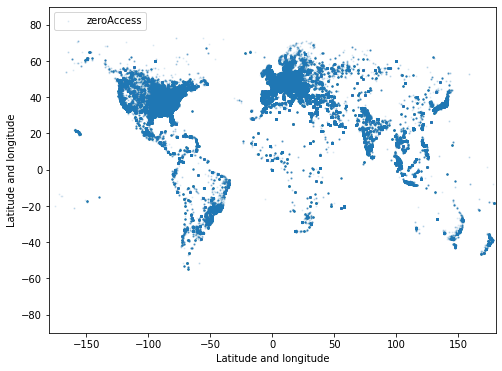

In [ ]:
# plot zeroAccess infection instances on a earth map
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.scatter(z_df.long, z_df.lat, alpha = 0.1, s = 1, label = "zeroAccess")
ax.set_xlim((-180, 180))
ax.set_ylim((-90, 90))

plt.xlabel("Latitude and longitude")
plt.ylabel("Latitude and longitude")
plt.legend(loc='upper left')

plt.show()

In [ ]:
# https://python-visualization.github.io/folium/quickstart.html

import folium
from folium.plugins import HeatMap
mapa = folium.Map(location=(10, 10), zoom_start=1.5, tiles="Stamen Toner", height="50%", width="50%")
loc_li = list(zip(list(z_df.lat), (z_df.long)))[:10000] # <-- change data size
HeatMap(loc_li, radius=15).add_to(mapa) # <-----------------------change radius
mapa

### Reverse Geocoding



In [ ]:
!pip install reverse_geocoder

     |████████████████████████████████| 2.2 MB 8.5 MB/s 
  Created wheel for reverse-geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268088 sha256=66d2080260a0daf0597dc76849822d1d5042b15f9170179652e022e50bff76ad
  Stored in directory: /root/.cache/pip/wheels/34/6e/70/5423639428a2cac8ea7eb467214a4254b549b381f306a9c790
Successfully built reverse-geocoder


In [ ]:
import reverse_geocoder

# {'lat': '51.51116', 'lon': '-0.18426', 'name': 'Bayswater', 
#  'admin1': 'England', 'admin2': 'Greater London', 'cc': 'GB'}

# quick implementation
def rgr(s):
  cord_li = [(s[0], s[1])]
  result_dict_li = reverse_geocoder.search(cord_li)
  ret_ser = pd.Series(dict(result_dict_li[0]))
  return ret_ser.drop(labels=['lat', 'lon'])

# batch implementation
def rgr_batch(lat_long_df):
  cord_li = []
  for ind in lat_long_df.index:
    cord_li.append((lat_long_df['lat'][ind], lat_long_df['long'][ind]))
  result_dict_li = reverse_geocoder.search(cord_li)
  return pd.DataFrame(result_dict_li).drop(["lat", "lon"], axis = 1)

In [ ]:
# quick implementation
'''
sample_df = z_df.head(50) # <------ only use some data, because it takes time
country_df = sample_df.apply(lambda s: rgr(s), axis = 1)
df = sample_df.join(country_df)
df
'''

'\nsample_df = z_df.head(50) # <------ only use some data, because it takes time\ncountry_df = sample_df.apply(lambda s: rgr(s), axis = 1)\ndf = sample_df.join(country_df)\ndf\n'

In [ ]:
# batch implementation
sample_df = z_df.head(50000) # <------ only use some data, because it takes time
country_df = rgr_batch(sample_df)
df = sample_df.join(country_df).rename(columns={'name':'City', 'admin1': 'State', 'admin2':'County', 'cc':"country_code", })
df

Loading formatted geocoded file...


,lat,long,City,State,County,country_code
0,-10.0000,-55.0000,Alta Floresta,Mato Grosso,Alta Floresta,BR
1,38.0888,-78.5592,Charlottesville,Virginia,City of Charlottesville,US
2,38.9990,-84.6266,Florence,Kentucky,Boone County,US
3,48.6210,7.4944,Marlenheim,Alsace,Departement du Bas-Rhin,FR
4,43.2342,-86.2484,Muskegon,Michigan,Muskegon County,US
...,...,...,...,...,...,...
49995,53.1271,18.0200,Bydgoszcz,Kujawsko-Pomorskie,Bydgoszcz,PL
49996,42.6757,-82.7773,New Baltimore,Michigan,Macomb County,US
49997,43.5417,21.7078,Aleksinac,Central Serbia,Nisavski Okrug,RS
49998,28.2397,-82.7388,New Port Richey,Florida,Pasco County,US


### Question #1:
Plot a figure to show # of attack in each country

In [ ]:
country=df['country_code'].value_counts()
country.to_frame().rename(columns={'country_code':'attack'})

,attack
US,23987
CA,2966
GB,2564
JP,1504
AU,1501
...,...
BJ,1
SO,1
AI,1
MC,1


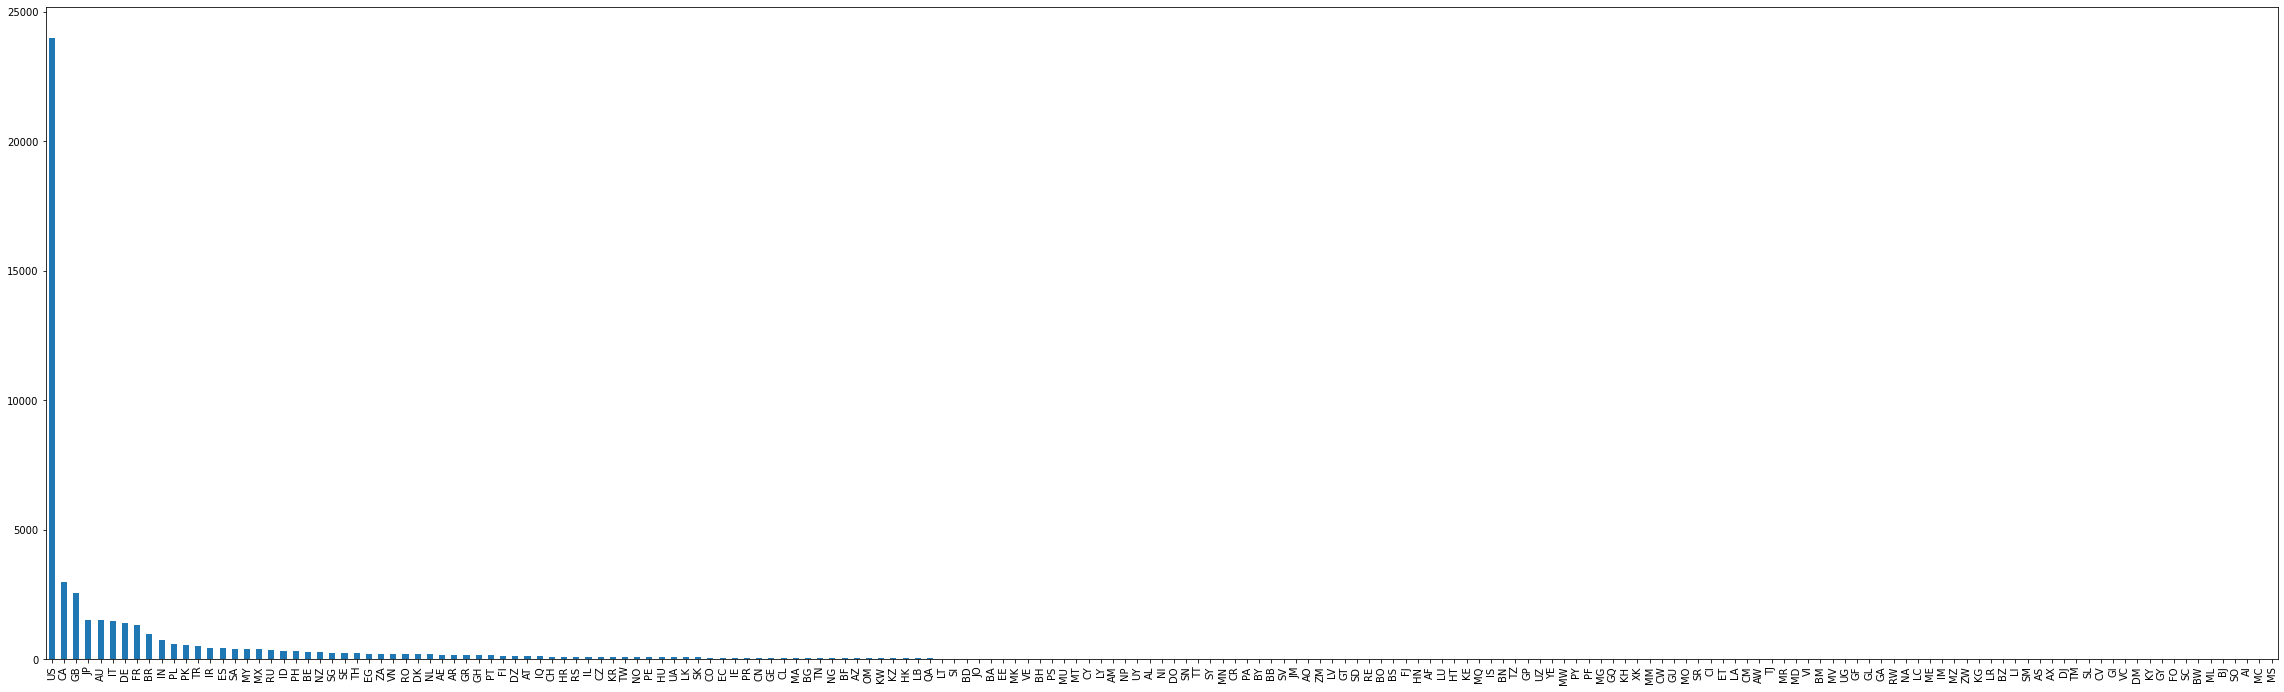

In [ ]:
country.plot(y=["Attack"], kind="bar",figsize=(40,12))

### Question #2:

Plot a figure to show % of attack in each country
Ignore countries that are < 1%

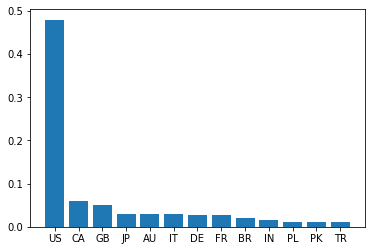

In [ ]:
frequency=[]#儲存受攻擊的%數(>=1%)
target=[]#儲存受攻擊%數>=1%的國家
for i,j in country.iteritems():
  if j/len(df)>=0.01:
    frequency.append(j/len(df))
    target.append(i)
plt.bar(target,frequency)
plt.show()

In [ ]:
for i,j in zip(target,frequency):
  print(i,j)

US 0.47974
CA 0.05932
GB 0.05128
JP 0.03008
AU 0.03002
IT 0.02964
DE 0.02824
FR 0.02622
BR 0.01928
IN 0.01496
PL 0.01154
PK 0.01096
TR 0.01052


### Question #3:

Only show US data and map.
Show US state data.

Which state/ciry has severe attack? Why?

Hint: recall a network tool named 'whois' ...


In [ ]:
us_df = df[df.country_code == 'US']
us_df

,lat,long,City,State,County,country_code
1,38.0888,-78.5592,Charlottesville,Virginia,City of Charlottesville,US
2,38.9990,-84.6266,Florence,Kentucky,Boone County,US
4,43.2342,-86.2484,Muskegon,Michigan,Muskegon County,US
6,44.8012,-68.7778,Bangor,Maine,Penobscot County,US
8,36.0580,-88.8253,Bradford,Tennessee,Gibson County,US
...,...,...,...,...,...,...
49992,40.6374,-79.7264,Brackenridge,Pennsylvania,Allegheny County,US
49994,38.4380,-122.6753,Santa Rosa,California,Sonoma County,US
49996,42.6757,-82.7773,New Baltimore,Michigan,Macomb County,US
49998,28.2397,-82.7388,New Port Richey,Florida,Pasco County,US


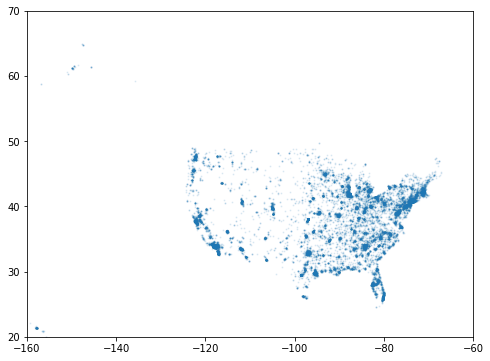

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.scatter(us_df.long, us_df.lat, alpha = 0.1, s = 1)
ax.set_xlim((-160,-60))
ax.set_ylim((20, 70))


plt.show()

In [ ]:
us_df['State'].value_counts()
#California State has the most attacks

California          2293
Texas               2003
Florida             1425
Kansas              1371
New York            1315
Pennsylvania         970
Illinois             948
Ohio                 914
Georgia              841
North Carolina       759
Michigan             715
New Jersey           669
Virginia             526
Arizona              503
Washington           502
Missouri             480
Wisconsin            472
Indiana              458
Massachusetts        453
Maryland             430
Tennessee            425
Alabama              412
Minnesota            405
Colorado             394
South Carolina       386
Kentucky             373
Louisiana            366
Oklahoma             293
Arkansas             262
Mississippi          241
Oregon               235
Iowa                 228
Connecticut          226
Nevada               187
Utah                 164
West Virginia        161
Nebraska             144
New Mexico           133
Maine                113
Idaho                 99


In [ ]:
us_df[['State','City']].value_counts()
#Peabody in Kansas has the most attacks

State           City       
Kansas          Peabody        1152
Texas           Houston         238
California      Los Angeles     179
Illinois        Chicago         144
Arizona         Phoenix         142
                               ... 
California      Dixon             1
Louisiana       Sulphur           1
                Springhill        1
North Carolina  Williamston       1
California      Mariposa          1
Length: 6660, dtype: int64

### Question #4:

Is there anything wrong with these states?

In [ ]:
att_pc=[]
for att in us_df['State'].value_counts():
  att_pc.append(att/len(us_df))
table=us_df['State'].value_counts().to_frame().rename(columns={'State':'attack'})
table['att_pc']=att_pc
table

,attack,att_pc
California,2293,0.095593
Texas,2003,0.083504
Florida,1425,0.059407
Kansas,1371,0.057156
New York,1315,0.054821
Pennsylvania,970,0.040439
Illinois,948,0.039521
Ohio,914,0.038104
Georgia,841,0.035061
North Carolina,759,0.031642


### Question #5:

Are the attack occurances in each state related to state population?

Try a bar chart!

In [ ]:
total=0
for p in s_df['population']:
  total=total+p
pop_pc=[]
for p in s_df['population']:
  pop_pc.append(p/total)

In [ ]:
data=pd.DataFrame(index=s_df['state'].tolist())
data['pop_pc']=pop_pc
data

,pop_pc
Alabama,0.015438
Arizona,0.021625
Arkansas,0.009473
California,0.121181
Colorado,0.016474
Connecticut,0.011535
Delaware,0.002902
District of Columbia,0.001966
Florida,0.060778
Georgia,0.032226


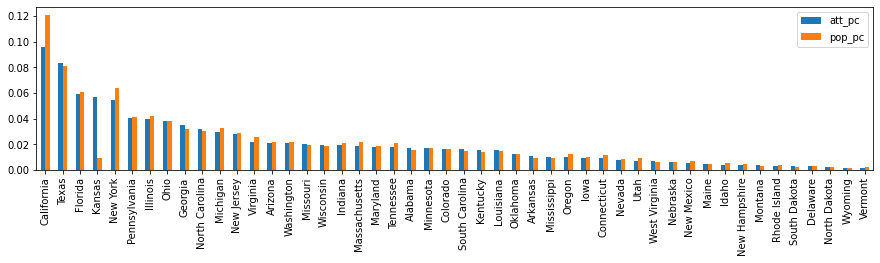

In [ ]:
newtable=table.join(data)
newtable=newtable.dropna(axis=0)
newtable.plot(y=["att_pc", "pop_pc"], kind="bar",figsize=(15,3))
plt.show()

### UFO?

Try to use county-data.csv data to predict the attack counts for each state by liner regression.

Which feature is the best?

In [ ]:
newc_df=c_df[['region','pop','income','ufo2010','ipaddr']].groupby('region')['pop','income','ufo2010','ipaddr'].sum()
newc_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,pop,income,ufo2010,ipaddr
region,,,,
alabama,4822023,2522962,250,22542601
arizona,6532974,612727,1250,62062174
arkansas,2949131,2677866,265,4810526
california,38041430,3241756,3769,156511903
colorado,5129284,3206281,513,22787577
connecticut,3590347,565060,280,40993589
delaware,917092,172156,74,19378182
district of columbia,632323,61835,1,10759507
florida,19317568,2990011,1465,23716071


In [ ]:
newtable.index=newtable.index.str.lower()
newc_df=newc_df.join(newtable)
newc_df=newc_df.dropna(axis=0)
newc_df

,pop,income,ufo2010,ipaddr,attack,att_pc,pop_pc
region,,,,,,,
alabama,4822023,2522962,250,22542601,412.0,0.017176,0.015438
arizona,6532974,612727,1250,62062174,503.0,0.020970,0.021625
arkansas,2949131,2677866,265,4810526,262.0,0.010923,0.009473
california,38041430,3241756,3769,156511903,2293.0,0.095593,0.121181
colorado,5129284,3206281,513,22787577,394.0,0.016426,0.016474
connecticut,3590347,565060,280,40993589,226.0,0.009422,0.011535
delaware,917092,172156,74,19378182,68.0,0.002835,0.002902
florida,19317568,2990011,1465,23716071,1425.0,0.059407,0.060778
georgia,9919945,6433814,548,20947043,841.0,0.035061,0.032226


In [ ]:
from sklearn.linear_model import LinearRegression
linearRegModel = LinearRegression()

In [ ]:
x_train=newc_df[['pop','income','ufo2010','ipaddr']]
y_train=newc_df['attack']
linearRegModel.fit(x_train, y_train)

LinearRegression()

In [ ]:
# print the intercept and coefficients 
print("Intercept is ", linearRegModel.intercept_)
print("coefficients  is ", linearRegModel.coef_)


# print with feature name
print()
print("attack = ")
for c,f in zip(linearRegModel.coef_, x_train.columns):
  print(' {0:+} * {1}'.format(c, f))
print("", linearRegModel.intercept_)

Intercept is  -12.76510413071236
coefficients  is  [ 6.11127167e-05  4.32120599e-05 -2.64018980e-02  1.37605988e-07]

attack = 
 +6.111271668738524e-05 * pop
 +4.321205988731145e-05 * income
 -0.02640189801197517 * ufo2010
 +1.3760598777746356e-07 * ipaddr
 -12.76510413071236


In [ ]:
import statsmodels.api as sm
results = sm.OLS(y_train, x_train).fit()
results.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 attack   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              199.5
Date:                Fri, 04 Mar 2022   Prob (F-statistic):                    1.38e-27
Time:                        05:30:52   Log-Likelihood:                         -311.51
No. Observations:                  48   AIC:                                      631.0
Df Residuals:                      44   BIC:                                      638.5
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
pop         6.162e-05   9.98e-06      6.175      0.000    4.15e-05    8.17e-05
income      4.028e-05    1.1e-05      3.657      0.001    1.81e-05    6.25e-05
ufo2010       -0.0333      0.103     -0.324      0.748      -0.241       0.174
ipaddr      1.216e-07   7.38e-07      0.165      0.870   -1.37e-06    1.61e-06
==============================================================================
Omnibus:                       93.113   Durbin-Watson:                   2.270
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2205.804
Skew:                           5.363   Prob(JB):                         0.00
Kurtosis:                      34.430   Cond. No.                     2.09e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.09e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Additional Materials

### GeoPy

Realtime network-based query. 
May limit query frequency.

https://geopy.readthedocs.io/en/stable/

In [ ]:
!pip install geopy

In [ ]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="my-application")
coordinates = "53.480837, -2.244914"
location = geolocator.reverse(coordinates)
print(location.address)
print((location.latitude, location.longitude))
print(location.raw)

Eagle Insurance Buildings, 68, Cross Street, City Centre, Manchester, Greater Manchester, North West England, England, M2 4NJ, United Kingdom
(53.4809597, -2.2450668274629235)
{'place_id': 111898782, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 37139875, 'lat': '53.4809597', 'lon': '-2.2450668274629235', 'display_name': 'Eagle Insurance Buildings, 68, Cross Street, City Centre, Manchester, Greater Manchester, North West England, England, M2 4NJ, United Kingdom', 'address': {'building': 'Eagle Insurance Buildings', 'house_number': '68', 'road': 'Cross Street', 'suburb': 'City Centre', 'city': 'Manchester', 'county': 'Greater Manchester', 'state_district': 'North West England', 'state': 'England', 'postcode': 'M2 4NJ', 'country': 'United Kingdom', 'country_code': 'gb'}, 'boundingbox': ['53.480856', '53.4810634', '-2.2451761', '-2.2449576']}


### Reverse Geocode

In [ ]:
!pip install reverse-geocode

     |████████████████████████████████| 1.6 MB 7.2 MB/s 
  Created wheel for reverse-geocode: filename=reverse_geocode-1.4.1-py3-none-any.whl size=1637841 sha256=f2963d179065d17bf2e120e3cf633be2a437d665d80596c186af2bbc4d0ed275
  Stored in directory: /root/.cache/pip/wheels/34/fd/8c/204b58f530154e61f182bcf1813a53b3ad5844faaff3df51d6
Successfully built reverse-geocode


In [ ]:
# need a package that can convert lat,long to contury code
# https://pypi.org/project/reverse-geocode/

import reverse_geocode

coordinates = [(51.5214588, -0.1729636)]
results = reverse_geocode.search(coordinates)

print(results[0])

{'country_code': 'GB', 'city': 'Bayswater', 'country': 'United Kingdom'}


### Reverse Geocoder

https://github.com/thampiman/reverse-geocoder


In [ ]:
 !pip install reverse_geocoder

In [ ]:
import reverse_geocoder

coordinates = [(51.5214588, -0.1729636)]
results = reverse_geocoder.search(coordinates) # default mode = 2

print(dict(results[0]))

{'lat': '51.51116', 'lon': '-0.18426', 'name': 'Bayswater', 'admin1': 'England', 'admin2': 'Greater London', 'cc': 'GB'}


In [ ]:
s_ = sample_df[:10]